<a href="https://colab.research.google.com/github/UrukHan/NeuroNetStockQuotes/blob/master/StockQuotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Импорт библиотек**

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers.advanced_activations import *

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV

from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(1)
tf.compat.v1.set_random_seed(1)

In [28]:
# Очистка журналов
!rm -rf ./logs/ 
!ls

sample_data  stockQuotes-5m.csv


# **Загрузка данных**

In [29]:
# Загрузка данных
allData = pd.read_csv('/content/stockQuotes-5m.csv')
allData.index = pd.DatetimeIndex(allData['date'])
allData.drop(['date'], axis=1, inplace=True)

# **Обработка данных**

In [30]:
# Определение времени для выбрки времени
allData = allData.query('index.dt.hour > 9 and index.dt.hour < 16')

In [31]:
# Проверка на отсутствующие значения
allDataNa = allData.isnull().sum()
allDataNa = allDataNa.drop(allDataNa[allDataNa == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :allDataNa})
missing_data.T

,EES-P,EES-V,CNY,AZO-P,AZO-V,GWW-V,GWW-P,EQIX-P,EQIX-V,RUB,CMG-P,CMG-V,ORCL-V,AIZ-V,ORCL-P,AIZ-P,WAT-P,WAT-V,JPY,CHF,ROP-P,ROP-V,SRCL-P,ORLY-V,ORLY-P,SRCL-V,SHW-V,SNA-P,SNA-V,ROK-V,EFX-V,EFX-P,FFIV-V,FFIV-P,HUM-V,HUM-P,ROK-P,ISRG-P,ISRG-V,MLM-P,MLM-V,MKC-P,MKC-V,MCO-P,SHW-P,REGN-P,REGN-V,MCO-V
Missing Ratio,428,428,55,28,28,20,20,19,19,11,8,8,5,5,5,5,5,5,3,3,3,3,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [32]:
allData = allData.drop(missing_data.T.columns[missing_data.T.gt(3).loc['Missing Ratio'].to_list()], axis=1)
allData.shape

(792, 820)

In [33]:
# Заполнение пропущенных значений
allData = allData.fillna(method='ffill')
allData = allData.fillna(method='bfill')

In [34]:
# Функция разделения данных на тренировочные и тестовые
def dataSplit(data, argP, biasY):
  data[argP] = data[argP].shift(-biasY)
  data = data[:-biasY]
  trainData, testData = train_test_split(data, test_size = 0.1, shuffle = False)
  return trainData, testData

In [35]:
data = dataSplit(allData, 'MMM-P', 5)
trainDataY = data[0]['MMM-P']
trainDataX = data[0].drop(['MMM-P'], axis = 1, inplace = False)
testDataY = data[1]['MMM-P']
testDataX = data[1].drop(['MMM-P'], axis = 1, inplace = False)
print(data[0].shape, data[1].shape)
print(trainDataX.shape, trainDataY.shape)
print(testDataX.shape, testDataY.shape)

(708, 820) (79, 820)
(708, 819) (708,)
(79, 819) (79,)


In [36]:
# Масштабирование нормализванных данных
scalerS = StandardScaler()
scalerS.fit(trainDataX)
trainDataXS = pd.DataFrame(scalerS.transform(trainDataX))
trainDataXS.columns = trainDataX.columns.tolist()
testDataXS = pd.DataFrame(scalerS.transform(testDataX))
testDataXS.columns = testDataX.columns.tolist()

In [37]:
# Прогноз LinearRegression на общих данных ненормированных
reg = LinearRegression().fit(trainDataXS, trainDataY)
predL = reg.predict(testDataXS)
for i in range(0, 50, 5):
    print("Предсказанная цена:", round(predL[i], 2), ", правильная цена:", round(testDataY.values[i], 2))
# Оценка погрешности
difference = predL - testDataY.values
print('\nСредняя ошибка', sum(abs(difference))/len(difference))

Предсказанная цена: 158.92 , правильная цена: 160.04
Предсказанная цена: 160.17 , правильная цена: 160.15
Предсказанная цена: 160.61 , правильная цена: 159.79
Предсказанная цена: 161.07 , правильная цена: 159.63
Предсказанная цена: 162.47 , правильная цена: 160.56
Предсказанная цена: 164.1 , правильная цена: 160.51
Предсказанная цена: 165.39 , правильная цена: 159.6
Предсказанная цена: 163.65 , правильная цена: 160.0
Предсказанная цена: 165.2 , правильная цена: 159.96
Предсказанная цена: 164.26 , правильная цена: 159.84

Средняя ошибка 3.5019487858245917


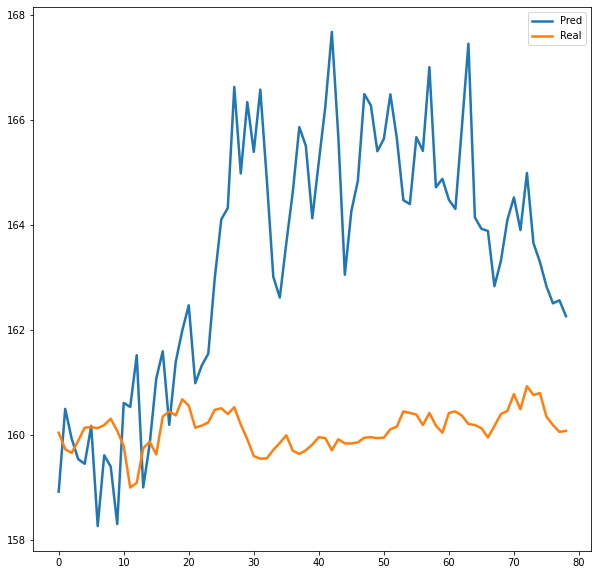

In [38]:
graphData = [predL, testDataY.values]
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=predL, palette="tab10", linewidth=2.5)
sns.lineplot(data=testDataY.values, palette="tab10", linewidth=2.5)
ax.legend(['Pred', 'Real'], facecolor='w')
plt.show()

In [39]:
# Вычисление изменения цены
allData = allData.diff().shift(-1)
allData = allData.dropna()
print(allData)

                      MMM-P    MMM-V   ABT-P  ...     CHF  JPY     GBP
date                                          ...                     
2020-09-11 10:00:00  0.1050  18262.0 -0.4550  ...  0.0000  0.0  0.0009
2020-09-11 10:05:00  0.0600 -18546.0  0.1050  ...  0.0000  0.0 -0.0003
2020-09-11 10:10:00  0.1200  -5348.0 -0.0400  ... -0.0007  0.0  0.0001
2020-09-11 10:15:00  0.3900   4228.0  0.0650  ...  0.0002  0.0 -0.0005
2020-09-11 10:20:00  0.4500  -7883.0  0.0881  ... -0.0004  0.0  0.0000
...                     ...      ...     ...  ...     ...  ...     ...
2020-09-25 15:05:00  0.0366   3079.0  0.0500  ...  0.0001  0.0 -0.0004
2020-09-25 15:10:00 -0.4490   8859.0  0.1700  ... -0.0004  0.0 -0.0009
2020-09-25 15:15:00 -0.1600  -5878.0 -0.0500  ... -0.0003  0.0  0.0010
2020-09-25 15:20:00 -0.1300    758.0  0.2400  ...  0.0004  0.0  0.0005
2020-09-25 15:25:00  0.0200   3914.0 -0.0500  ... -0.0001  0.0 -0.0004

[786 rows x 820 columns]


In [40]:
data = dataSplit(allData, 'MMM-P', 1)
trainDataY = data[0]['MMM-P']
trainDataX = data[0].drop(['MMM-P'], axis = 1, inplace = False)
testDataY = data[1]['MMM-P']
testDataX = data[1].drop(['MMM-P'], axis = 1, inplace = False)
print(data[0].shape, data[1].shape)
print(trainDataX.shape, trainDataY.shape)
print(testDataX.shape, testDataY.shape)

(706, 820) (79, 820)
(706, 819) (706,)
(79, 819) (79,)


In [41]:
# Средний шаг скачков цен акций
testDiff = testDataY.diff().shift(-3)
testDiff = testDiff.dropna()
print(sum(abs(testDiff))/len(testDiff))

0.2463973684210516


In [42]:
# Среднее значение и стандартное отклонение
mean = trainDataX.mean(axis=0)
std = trainDataX.std(axis=0)
# Нормализация данных
trainDataXN = (trainDataX - mean)/std
testDataXN = (testDataX - mean)/std

# **Создание и тестирование моделей**

In [43]:
# Прогноз LinearRegression на общих данных ненормированных
reg = LinearRegression().fit(trainDataXN, trainDataY)
predL = reg.predict(testDataXN)
for i in range(0, 50, 5):
    print("Предсказанная цена:", round(predL[i], 2), ", правильная цена:", round(testDataY.values[i], 2))
# Оценка погрешности
difference = predL - testDataY.values
print('\nСредняя ошибка', sum(abs(difference))/len(difference))

Предсказанная цена: 0.71 , правильная цена: -0.02
Предсказанная цена: -1.67 , правильная цена: 0.01
Предсказанная цена: 0.93 , правильная цена: -0.29
Предсказанная цена: 1.96 , правильная цена: -0.24
Предсказанная цена: 2.11 , правильная цена: -0.12
Предсказанная цена: 1.93 , правильная цена: 0.03
Предсказанная цена: 0.9 , правильная цена: -0.32
Предсказанная цена: -0.09 , правильная цена: 0.15
Предсказанная цена: 0.28 , правильная цена: 0.14
Предсказанная цена: 0.41 , правильная цена: 0.0

Средняя ошибка 0.8378783052588366


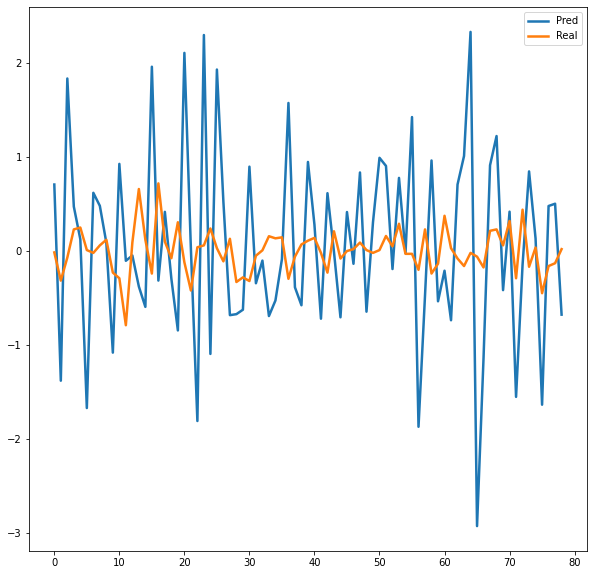

In [44]:
graphData = [predL, testDataY.values]
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=predL, palette="tab10", linewidth=2.5)
sns.lineplot(data=testDataY.values, palette="tab10", linewidth=2.5)
ax.legend(['Pred', 'Real'], facecolor='w')
plt.show()

In [45]:
# Прогноз RandomForestRegressor на общих данных ненормированных
rfr = RandomForestRegressor(n_estimators = 5, criterion = 'mae', max_depth = 5).fit(trainDataXN, trainDataY)
predRFR = rfr.predict(testDataXN)
for i in range(0, 50, 5):
    print("Предсказанная цена:", round(predRFR[i], 2), ", правильная цена:", round(testDataY.values[i], 2))
difference = predRFR - testDataY.values
print('\nСредняя ошибка', sum(abs(difference))/len(difference))

Предсказанная цена: 0.07 , правильная цена: -0.02
Предсказанная цена: 0.05 , правильная цена: 0.01
Предсказанная цена: -0.02 , правильная цена: -0.29
Предсказанная цена: 0.02 , правильная цена: -0.24
Предсказанная цена: -0.06 , правильная цена: -0.12
Предсказанная цена: 0.11 , правильная цена: 0.03
Предсказанная цена: -0.02 , правильная цена: -0.32
Предсказанная цена: 0.02 , правильная цена: 0.15
Предсказанная цена: 0.02 , правильная цена: 0.14
Предсказанная цена: 0.11 , правильная цена: 0.0

Средняя ошибка 0.16254784810126385


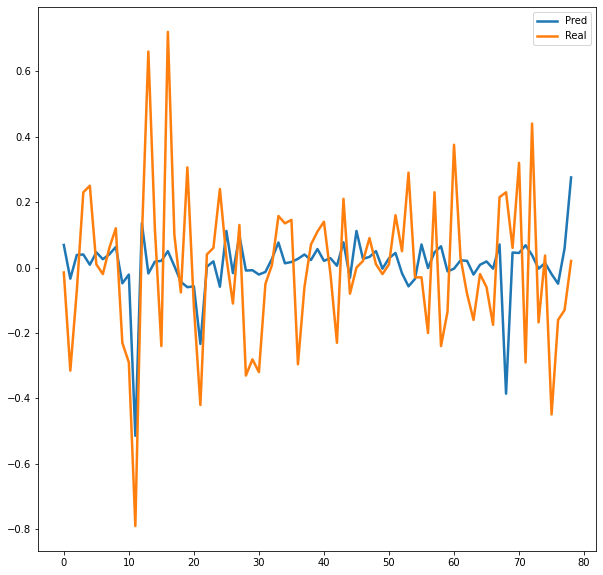

In [46]:
graphData = [predRFR, testDataY.values]
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=predRFR, palette="tab10", linewidth=2.5)
sns.lineplot(data=testDataY.values, palette="tab10", linewidth=2.5)
ax.legend(['Pred', 'Real'], facecolor='w')
plt.show()

# **Создание нейронной сети**

In [47]:
#  Класс отображения хода обучения сети
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 15 == 0: print('')
    print('.', end = '')
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [48]:
def createModel(inputShape):
    model = Sequential()
    model.add(Dense(16384, input_dim = inputShape, kernel_regularizer=keras.regularizers.l2(0.01), activation = "relu"))
    model.add(Dense(8192, activation = "relu"))
    model.add(Dense(4096, activation = "relu"))
    model.add(Dense(2048, activation = "relu"))
    model.add(Dense(1024, activation = "relu"))
    model.add(Dense(1024, activation = "relu"))
    model.add(layers.Dropout(0.05))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss = 'mae', optimizer = optimizer, metrics = ["mse", "mae"])
    return model

In [49]:
modelG = createModel(trainDataXN.shape[1])
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
history = modelG.fit(trainDataXN, trainDataY, validation_split = 0.2, batch_size = 80, epochs = 10, verbose = 1, callbacks = [early_stop, PrintDot()])

Epoch 1/10
8/8 [==============================] - 21s 3s/step - loss: 15.7483 - mse: 0.1366 - mae: 0.2000 - val_loss: 15.6455 - val_mse: 0.0577 - val_mae: 0.1811
Epoch 2/10
8/8 [==============================] - 21s 3s/step - loss: 15.5770 - mse: 0.1245 - mae: 0.1587 - val_loss: 15.5263 - val_mse: 0.0630 - val_mae: 0.1831
Epoch 3/10
8/8 [==============================] - 21s 3s/step - loss: 15.4271 - mse: 0.1044 - mae: 0.1249 - val_loss: 15.4209 - val_mse: 0.0667 - val_mae: 0.1866
Epoch 4/10
8/8 [==============================] - 21s 3s/step - loss: 15.3076 - mse: 0.0998 - mae: 0.1135 - val_loss: 15.3117 - val_mse: 0.0654 - val_mae: 0.1840
Epoch 5/10
8/8 [==============================] - 21s 3s/step - loss: 15.1891 - mse: 0.0924 - mae: 0.1014 - val_loss: 15.2050 - val_mse: 0.0611 - val_mae: 0.1835
Epoch 6/10
8/8 [==============================] - 21s 3s/step - loss: 15.0720 - mse: 0.0848 - mae: 0.0907 - val_loss: 15.1025 - val_mse: 0.0664 - val_mae: 0.1870
Epoch 7/10
8/8 [============

In [50]:
# Предсказание значений
predsData = modelG.predict(testDataXN)
for i in range(10):
    print("Предсказанный рост:", round(predsData[i][0], 3), ", правильный рост:", round(testDataY.values[i], 3))
difference = predsData.T[0] - testDataY.values
print('\nСредняя ошибка', sum(abs(difference))/len(difference))

Предсказанный рост: -0.048 , правильный рост: -0.015
Предсказанный рост: -0.118 , правильный рост: -0.315
Предсказанный рост: 0.007 , правильный рост: -0.07
Предсказанный рост: 0.001 , правильный рост: 0.23
Предсказанный рост: -0.001 , правильный рост: 0.25
Предсказанный рост: -0.121 , правильный рост: 0.01
Предсказанный рост: -0.029 , правильный рост: -0.02
Предсказанный рост: -0.105 , правильный рост: 0.06
Предсказанный рост: -0.065 , правильный рост: 0.12
Предсказанный рост: -0.122 , правильный рост: -0.23

Средняя ошибка 0.18119122444119032


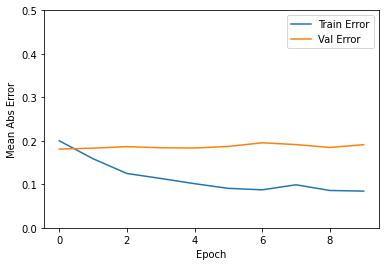

In [51]:
# График хода обучения
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0, 0.5])
  plt.legend()

plot_history(history)

In [52]:
# Создание функции для кросс валидации
def crossValdation(modelTF, dataSetX, dataSetY, printD):
  epohs = 5
  batch = 30
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
  histMean = pd.DataFrame({'loss':[], 'mse':[], 'mae':[], 'val_loss':[], 'val_mse':[], 'val_mae':[], 'epoch':[]})
  skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
  for trainIndex, validIndex in skf.split(dataSetX, dataSetY.astype(int)):
    trainX = trainDataX.iloc[trainIndex]
    trainY = trainDataY.iloc[trainIndex]
    validX = trainDataX.iloc[validIndex]
    validY = trainDataY.iloc[validIndex]
    modelG = modelTF(trainX.shape[1])
    history = modelG.fit(trainX, trainY, validation_data = (validX, validY), batch_size = batch, epochs = epohs, verbose = 2, callbacks = [early_stop, printD])
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    histMean = histMean.append(hist.iloc[[-1]], ignore_index = True)
  
  del histMean['epoch']    
  tir = pd.DataFrame({'loss':['---'], 'mse':['---'], 'mae':['---'], 'val_loss':['---'], 'val_mse':['---'], 'val_mae':['---']})
  histM = pd.DataFrame(histMean.mean()).T
  histMean = histMean.append(tir)
  histMean = histMean.append(histM)
  return histMean, modelG, hist

In [ ]:
startModelTest = crossValdation(createModel, trainDataXN, trainDataY, PrintDot())
modelTest = startModelTest[1]
hist = startModelTest[2]
startModelTest[0]

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/5

.19/19 - 39s - loss: 4066.6924 - mse: 39711792.0000 - mae: 4051.1858 - val_loss: 1556.1207 - val_mse: 4277033.5000 - val_mae: 1540.7268
Epoch 2/5
.19/19 - 39s - loss: 3868.5146 - mse: 62677964.0000 - mae: 3853.2207 - val_loss: 1886.8018 - val_mse: 8273337.5000 - val_mae: 1871.6193
Epoch 3/5
.19/19 - 38s - loss: 1939.8323 - mse: 17783310.0000 - mae: 1924.7478 - val_loss: 1915.2944 - val_mse: 6811297.5000 - val_mae: 1900.3199
Epoch 4/5
.19/19 - 38s - loss: 2264.0659 - mse: 32766718.0000 - mae: 2249.1873 - val_loss: 874.1055 - val_mse: 1585968.0000 - val_mae: 859.3348
Epoch 5/5
.19/19 - 38s - loss: 1780.0787 - mse: 12145822.0000 - mae: 1765.4021 - val_loss: 1175.6014 - val_mse: 2942730.2500 - val_mae: 1161.0305
Epoch 1/5

.19/19 - 35s - loss: 4214.5522 - mse: 42199908.0000 - mae: 4199.0439 - val_loss: 3270.3613 - val_mse: 26453108.0000 - val_mae: 3254.9680
Epoch 2/5
.19/19 - 34s - loss: 3896.6274 - mse: 68163408.0000 - mae: 3881.3345 - val_loss: 2184.1135 - val_mse: 9228202.000

In [ ]:
pred = modelTest.predict(testDataXN).flatten()
for i in range(0, 50, 5):
    print("Предсказанная цена:", round(pred[i], 4), ", правильная цена:", round(testDataY.values[i], 4))
difference = pred - testDataY.values
print('\nСредняя ошибка', sum(abs(difference))/len(difference))

In [ ]:
# Просмотр корреляции данных
correlation = allData.iloc[:,:25].corr()
plt.figure(figsize = (17,17))
sns.heatmap(correlation, vmax = 1, square = True, annot = True, cmap = 'Blues')